## IMPORTS

In [1]:
import numpy as np
import h5py
#data file type h5py
import time
import copy
import matplotlib.pyplot as plt
from random import randint

## INPUT

In [2]:
#load MNIST data
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
MNIST_data.close()

## LOGISTIC REGRESSION

In [44]:
#class LR:
def load_mnist(filename):
    """load MNIST data"""
    MNIST_data = h5py.File(filename, 'r')
    x_train = np.float32(MNIST_data['x_train'][:])
    y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
    x_test = np.float32(MNIST_data['x_test'][:])
    y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
    MNIST_data.close()
    return x_train,y_train,x_test,y_test
    
def initialize(num_inputs,num_classes):
    """initialize the parameters"""
    # num_inputs = 28*28 = 784
    # num_classes = 10
    w = np.random.randn(num_classes, num_inputs) / np.sqrt(num_classes*num_inputs) # (10*784)
    b = np.random.randn(num_classes, 1) / np.sqrt(num_classes) # (10*1) 
    
    param = {
        'w' : w, # (10*784)
        'b' : b  # (10*1)
    }
    return param
    
def softmax(z):
    """implement the softmax functions
    input: numpy ndarray
    output: numpy ndarray
    """
    exp_list = np.exp(z)
    result = 1/sum(exp_list) * exp_list
    result = result.reshape((len(z),1))
    assert (result.shape == (len(z),1))
    return result
    
def neg_log_loss(pred, label):
    """implement the negative log loss"""
    loss = -np.log(pred[int(label)])
    return loss

def mini_batch_gradient(param, x_batch, y_batch):
    """implement the function to compute the mini batch gradient
    input: param -- parameters dictionary (w, b)
        x_batch -- a batch of x (size, 784)
        y_batch -- a batch of y (size,)
    output: dw, db, batch_loss
    """
    batch_size=x_batch.shape[0]
    w_grad_list = []
    b_grad_list = []
    batch_loss = 0
    for i in range(batch_size):
        x,y = x_batch[i],y_batch[i]
        x = x.reshape((784,1)) # x: (784,1)
        E = np.zeros((10,1)) #(10*1)
        E[y][0] = 1 
        pred = softmax(np.matmul(param['w'], x)+param['b']) #(10*1)

        loss = neg_log_loss(pred, y)
        batch_loss += loss

        w_grad = E - pred
        w_grad = - np.matmul(w_grad, x.reshape((1,784)))
        w_grad_list.append(w_grad)

        b_grad = -(E - pred)
        b_grad_list.append(b_grad)

    dw = sum(w_grad_list)/batch_size
    db = sum(b_grad_list)/batch_size
    return dw, db, batch_loss

def eval(param, x_data, y_data):
    """ implement the evaluation function
    input: param -- parameters dictionary (w, b)
            x_data -- x_train or x_test (size, 784)
            y_data -- y_train or y_test (size,)
    output: loss and accuracy
    """
    # w: (10*784), x: (10000*784), y:(10000,)
    loss_list = []
    w = param['w'].transpose()
    dist = np.array([np.squeeze(softmax(np.matmul(x_data[i], w))) for i in range(len(y_data))])

    result = np.argmax(dist,axis=1)
    accuracy = sum(result == y_data)/float(len(y_data))

    loss_list = [neg_log_loss(dist[i],y_data[i]) for i in range(len(y_data))]
    loss = sum(loss_list)
    return loss, accuracy

def train(param, hyp , x_train, y_train, x_test, y_test):
    """ implement the train function
    input: param -- parameters dictionary (w, b)
            hyp -- hyperparameters dictionary
            x_train -- (60000, 784)
            y_train -- (60000,)
            x_test -- x_test (10000, 784)
            y_test -- y_test (10000,)
    output: test_loss_list, test_accu_list
    """
    num_epoches = hyp['num_epoches']
    batch_size = hyp['batch_size']
    learning_rate = hyp['learning_rate']
    mu = hyp['mu']
    test_loss_list, test_accu_list = [],[]
    if bool(hyp['momentum']) == True:
        w_velocity = np.zeros(param['w'].shape)
        b_velocity = np.zeros(param['b'].shape) 

    for epoch in range(num_epoches):
        
        # select the random sequence of training set
        rand_indices = np.random.choice(x_train.shape[0],x_train.shape[0],replace=False)
        num_batch = int(x_train.shape[0]/batch_size)
        batch_loss100 = 0
        
        if bool(hyp['learning_decay']) == True:
            try:
                if test_accu_list[-1] - test_accu_list[-2] < 0.001:
                    learning_rate *= hyp['decay_factor']
            except:
                pass
            
            message = 'learning rate: %.8f' % learning_rate
            print(message)
            
        # for each batch of train data
        for batch in range(num_batch):
            index = rand_indices[batch_size*batch:batch_size*(batch+1)]
            x_batch = x_train[index]
            y_batch = y_train[index]

            # calculate the gradient w.r.t w and b
            dw, db, batch_loss = mini_batch_gradient(param, x_batch, y_batch)
            batch_loss100 += batch_loss
            # update the parameters with the learning rate
            if bool(hyp['momentum']) == True:
                w_velocity = mu * w_velocity + learning_rate * dw
                b_velocity = mu * b_velocity + learning_rate * db
                param['w'] -= w_velocity
                param['b'] -= b_velocity
            else:
                param['w'] -= learning_rate * dw
                param['b'] -= learning_rate * db
            if batch % 100 == 0:
                message = 'Epoch %d, Batch %d, Loss %.2f' % (epoch, batch, batch_loss)
                print(message)
                # logging.info(message)

                batch_loss100 = 0
        train_loss, train_accu = eval(param,x_train,y_train)
        test_loss, test_accu = eval(param,x_test,y_test)
        test_loss_list.append(test_loss)
        test_accu_list.append(test_accu)

        message = 'Epoch %d, Train Loss %.2f, Train Accu %.4f, Test Loss %.2f, Test Accu %.4f' % (epoch, train_loss, train_accu, test_loss, test_accu)
        print(message)
        #logging.info(message)
    return test_loss_list, test_accu_list



def plot(loss_list, accu_list):
    """store the plots"""
    # epoch_list = list(range(len(loss_list)))
    plt.plot(loss_list)
    plt.xlim([0, 15])
    plt.ylabel('Loss Function')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    
    plt.title('Loss Function ~ Epoch')
    plt.show()

    plt.plot(accu_list)
    plt.xlim([0, 15])
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Test Accuracy ~ Epoch')
    plt.show()

## Logistic Regression Model for MNIST

learning rate: 0.00500000
Epoch 0, Batch 0, Loss 23.60
Epoch 0, Batch 100, Loss 18.58
Epoch 0, Batch 200, Loss 16.66
Epoch 0, Batch 300, Loss 12.11
Epoch 0, Batch 400, Loss 12.80
Epoch 0, Batch 500, Loss 10.55
Epoch 0, Batch 600, Loss 8.13
Epoch 0, Batch 700, Loss 11.30
Epoch 0, Batch 800, Loss 7.74
Epoch 0, Batch 900, Loss 8.23
Epoch 0, Batch 1000, Loss 9.81
Epoch 0, Batch 1100, Loss 7.11
Epoch 0, Batch 1200, Loss 7.20
Epoch 0, Batch 1300, Loss 6.52
Epoch 0, Batch 1400, Loss 5.67
Epoch 0, Batch 1500, Loss 10.49
Epoch 0, Batch 1600, Loss 7.82
Epoch 0, Batch 1700, Loss 2.30
Epoch 0, Batch 1800, Loss 7.34
Epoch 0, Batch 1900, Loss 5.91
Epoch 0, Batch 2000, Loss 5.98
Epoch 0, Batch 2100, Loss 4.23
Epoch 0, Batch 2200, Loss 6.03
Epoch 0, Batch 2300, Loss 7.71
Epoch 0, Batch 2400, Loss 3.27
Epoch 0, Batch 2500, Loss 3.52
Epoch 0, Batch 2600, Loss 4.98
Epoch 0, Batch 2700, Loss 5.40
Epoch 0, Batch 2800, Loss 4.72
Epoch 0, Batch 2900, Loss 8.51
Epoch 0, Batch 3000, Loss 4.74
Epoch 0, Batch 31

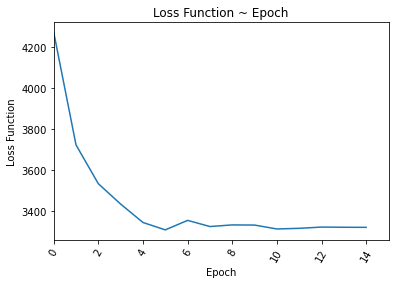

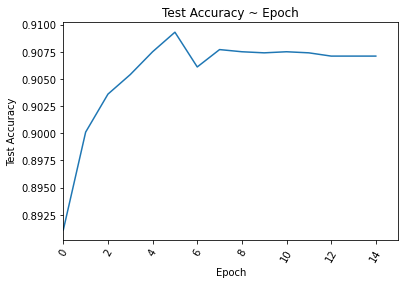

In [45]:
x_train,y_train,x_test,y_test = load_mnist('MNISTdata.hdf5')
np.random.seed(1024)
num_inputs = x_train.shape[1]
num_classes = len(set(y_train))
param = initialize(num_inputs,num_classes)
hyperpara = {
    "num_epoches" : 15,
    "batch_size" : 10,
    "learning_rate" : 0.005,
    "learning_decay" : 1,
    "decay_factor" : 0.5,
    "momentum" : 0,
    "mu" : 0.9
}

# train the model
loss_list, accu_list = train(param,hyperpara,x_train,y_train,x_test,y_test)

# plot the loss and accuracy
plot(loss_list, accu_list)

# KNN MODEL 

In [15]:
x_train,y_train,x_test,y_test = load_mnist('MNISTdata.hdf5')

In [16]:
def euclidean(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))
def knnn(X_train, y_train, test_point, k=2):
    
    distances = [] # Contains list of tuples (distance, label
    
    for data_point, label in zip(X_train, y_train):
        distances.append((euclidean(test_point, data_point), label))
   
    
    sorted_distances = sorted(distances, key=lambda x: x[0])
    k_nearest_neighbors = np.array(sorted_distances[:k])
    freq = np.unique(k_nearest_neighbors[:,1], return_counts=True)
    labels, counts = freq
    majority_vote = labels[counts.argmax()]
    return majority_vote
def calculate_accuracy(X_test, y_test, X_train, y_train, k=2):
    
    predictions = []
    
    for test_point in X_test:
        pred_label = knnn(X_train, y_train, test_point, k)
        predictions.append(pred_label)
        #print(test_point)
    
    predictions = np.array(predictions)
    #print(predictions)
    print(len(predictions))
    print(len(y_test))
    accuracy = (predictions == y_test).sum() / y_test.shape[0]
    return accuracy


In [17]:
no=[]
nk=[]

In [29]:
#1000 Samples

In [18]:

X_trainmin1, y_trainmin1 = x_train[:1000],y_train[:1000]

print(len(X_trainmin1))
print(len(y_trainmin1))
ac=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=2)
print(ac)
no.append(ac)

1000
1000
10000
10000
0.8496


In [30]:
#5000 samples

In [19]:
X_trainmin1, y_trainmin1 = x_train[:5000],y_train[:5000]

print(len(X_trainmin1))
print(len(y_trainmin1))
ac1=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=2)
print(ac1)
no.append(ac1)

5000
5000
10000
10000
0.9227


In [31]:
#10000 samples

In [20]:
X_trainmin1, y_trainmin1 = x_train[:10000],y_train[:10000]

print(len(X_trainmin1))
print(len(y_trainmin1))
ac2=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=2)
print(ac2)
no.append(ac2)

10000
10000
10000
10000
0.9335


In [32]:
#60000 samples with k=2

In [21]:
X_trainmin1, y_trainmin1 = x_train,y_train

print(len(X_trainmin1))
print(len(y_trainmin1))
ac4=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=2)
print(ac4)
no.append(ac4)
nk.append(ac4)

60000
60000
10000
10000
0.9627


In [33]:
#60000 samples with k=3

In [22]:
X_trainmin1, y_trainmin1 = x_train,y_train

print(len(X_trainmin1))
print(len(y_trainmin1))
ac5=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=3)
print(ac5)
nk.append(ac5)

60000
60000
10000
10000
0.9705


In [34]:
#60000 samples with k=5

In [23]:
X_trainmin1, y_trainmin1 = x_train,y_train

print(len(X_trainmin1))
print(len(y_trainmin1))
ac6=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=5)
print(ac6)
nk.append(ac6)

60000
60000
10000
10000
0.9688


In [35]:
#60000 samples with k=7

In [24]:
X_trainmin1, y_trainmin1 = x_train,y_train

print(len(X_trainmin1))
print(len(y_trainmin1))
ac7=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=7)
print(ac7)
nk.append(ac7)

60000
60000
10000
10000
0.9694


In [36]:
#60000 samples with k=9

In [25]:
X_trainmin1, y_trainmin1 = x_train,y_train

print(len(X_trainmin1))
print(len(y_trainmin1))
ac8=calculate_accuracy(x_test,y_test, X_trainmin1, y_trainmin1, k=9)
print(ac8)
nk.append(ac8)

60000
60000
10000
10000
0.9659


# 5 Fold Cross validation

In [26]:
def cross_validation(X,f,y):
    k=[1,3,5,7,9]
    d=(x_train.shape[0])/5
    best = {}
    for k in k:
        print("K:",k)
        t_acc=0
        for fold in range(f):
            l=int(fold*d)
            r=int(fold*d+d)
            t_s = X[l:r]
            t_s_l=y[l:r]
            c_pr=0
            for test_sample,test_label in zip(t_s,t_s_l):
                
                tmp=knnn(np.delete(X,np.s_[l:r],axis=0),np.delete(y,np.s_[l:r],axis=0),test_sample,k)
                #print(tmp)
                if(tmp==test_label):
                    c_pr+=1
            print("Fold "+str(fold+1)+" Classification Accuracy: ",c_pr/d)
            t_acc+=(c_pr/d)
        best[k]=t_acc/f
        print("Average Accuracy ",t_acc/f)
    print("\nOptimal K: ", max(best, key=best.get))



In [37]:
cross_validation(x_train,5,y_train)

K: 1
Fold 1 Classification Accuracy:  0.97
Fold 2 Classification Accuracy:  0.9701666666666666
Fold 3 Classification Accuracy:  0.96925
Fold 4 Classification Accuracy:  0.9693333333333334
Fold 5 Classification Accuracy:  0.9681666666666666
Average Accuracy  0.9693833333333334
K: 3
Fold 1 Classification Accuracy:  0.97175
Fold 2 Classification Accuracy:  0.9705
Fold 3 Classification Accuracy:  0.9688333333333333
Fold 4 Classification Accuracy:  0.9689166666666666
Fold 5 Classification Accuracy:  0.9704166666666667
Average Accuracy  0.9700833333333334
K: 5
Fold 1 Classification Accuracy:  0.96975
Fold 2 Classification Accuracy:  0.9698333333333333
Fold 3 Classification Accuracy:  0.9689166666666666
Fold 4 Classification Accuracy:  0.969
Fold 5 Classification Accuracy:  0.9688333333333333
Average Accuracy  0.9692666666666666
K: 7
Fold 1 Classification Accuracy:  0.9680833333333333
Fold 2 Classification Accuracy:  0.96925
Fold 3 Classification Accuracy:  0.9665
Fold 4 Classification Accura

In [27]:
print(no)

[0.8496, 0.9227, 0.9335, 0.9627]


In [28]:
print(nk)

[0.9627, 0.9705, 0.9688, 0.9694, 0.9659]


In [29]:
xs=[1000,5000,10000,60000]

In [30]:
xd=[2,3,5,7,9]

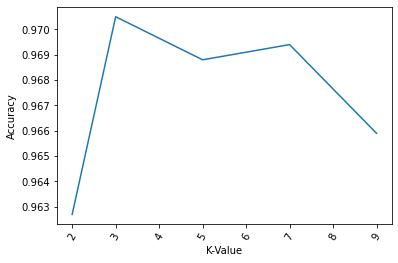

In [37]:
plt.plot(xd,nk)
plt.ylabel('Accuracy')
plt.xlabel('K-Value')
plt.xticks(rotation=60)

plt.show()

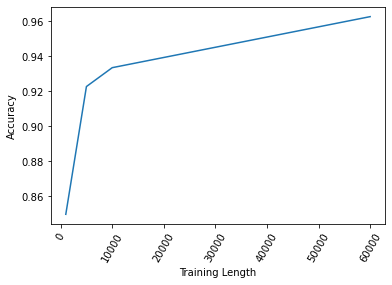

In [36]:
plt.plot(xs,no)
plt.ylabel('Accuracy')
plt.xlabel('Training Length')
plt.xticks(rotation=60)

plt.show()

# CNN MODEL

In [15]:
xtrain,ytrain,xtest,ytest = load_mnist('MNISTdata.hdf5')

Training data:


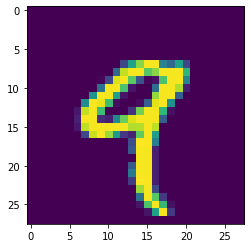

Label of this image is 9


In [18]:
import matplotlib.pyplot as plt
#What mnist images look like
import matplotlib.pyplot as plt
print("Training data:")
plt.imshow(xtrain[4])
plt.show()
print("Label of this image is",ytrain[4])

In [19]:
xtrain=np.reshape(xtrain,(-1,28,28,1))
xtest=np.reshape(xtest,(-1,28,28,1))
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

In [20]:
#normalising
xtrain=xtrain/255
xtest=xtest/255

In [21]:
#implementing one hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(ytrain, num_classes=10)
y_test = to_categorical(ytest, num_classes=10)

In [22]:
#importing the model
from keras.models import Sequential

In [23]:
#creating model object
model=Sequential()

In [24]:
#importing layers
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [25]:
#adding layers and forming the model
model.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10,activation="sigmoid"))

In [26]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [27]:
#training the model
model.fit(xtrain,y_train,batch_size=100,epochs=5,validation_data=(xtest,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 214s 4ms/step - loss: 0.8729 - accuracy: 0.7011 - val_loss: 0.2654 - val_accuracy: 0.9177
Epoch 2/5
60000/60000 [==============================] - 220s 4ms/step - loss: 0.2260 - accuracy: 0.9307 - val_loss: 0.1387 - val_accuracy: 0.9546
Epoch 3/5
60000/60000 [==============================] - 223s 4ms/step - loss: 0.1484 - accuracy: 0.9538 - val_loss: 0.1038 - val_accuracy: 0.9666
Epoch 4/5
60000/60000 [==============================] - 225s 4ms/step - loss: 0.1113 - accuracy: 0.9651 - val_loss: 0.0777 - val_accuracy: 0.9753
Epoch 5/5
60000/60000 [==============================] - 227s 4ms/step - loss: 0.0899 - accuracy: 0.9721 - val_loss: 0.0713 - val_accuracy: 0.9761


In [28]:
#model train and test scores
model.evaluate(xtrain,y_train),model.evaluate(xtest,y_test)

10000/10000 [==============================] - 15s 2ms/step


([0.07223058651859561, 0.9778000116348267],
 [0.07133920669127256, 0.9761000275611877])